In [1]:
#pip install opendatasets
#pip install kaggle


In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
torch.cuda.is_available()


False

In [3]:
#Load kaggle datasets
od.download("https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data")

#username : nay2010
#key: 286d8c9c720308131bf272ad86bccf20

Skipping, found downloaded files in ".\store-sales-time-series-forecasting" (use force=True to force download)


In [192]:
#forecating OIL data
df = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")
df['date'] = pd.to_datetime(df['date'])
'''
df.head()
df.index = df['date']
del df['date']
df.head()
'''

"\ndf.head()\ndf.index = df['date']\ndel df['date']\ndf.head()\n"

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21


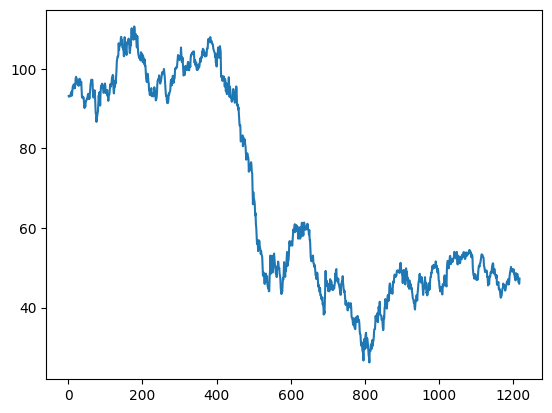

In [193]:
df=df.dropna()
plt.plot(df.index, df['dcoilwtico'])
df.head()

In [194]:
#standardizing data for 0 mean and 1 std

from sklearn.preprocessing import StandardScaler 

scaler = {} 

for cols in df.columns:
    scaler[cols] = StandardScaler().fit(df[cols].values.reshape(-1,1))
    
df2 = df.copy()

for cols in df.columns:
    df[cols] = scaler[cols].transform(df[cols].values.reshape(-1,1))

df2

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [195]:
#generating sequences for values and following predictions 
# lookback (lb) -> how many steps in past needed
#target (tp) -> value ater lb timesteps 

def sequence_generation(df, lb, tp):
    data = dict()
    L = len(df)
    for t in range(L-lb):
        sequence = df.iloc[t:t+lb,:].values
        target = df.iloc[t+lb:t+lb+tp].values

        data[t] = {'sequence':sequence, 'target': target}

    return data

def date_generation(df, lb):
    dates=[]
    L = len(df)
    for t in range(L-lb):
        dates.append(df.iloc[t].values)

    return dates


In [196]:
#creating a dataset class for pytorch loading

class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [212]:
#data loading 

BATCH_SIZE = 16
train_split = 0.8 
sequence_len = 180 # Training Window

data_sequence = sequence_generation(df['dcoilwtico'].to_frame(), sequence_len, 1)
dates=date_generation(df2['date'].to_frame(),sequence_len)

dataset = SequenceDataset(data_sequence)

#split and load into pytorch 
len_train = int(train_split*len(dataset))
len_test = (len(dataset)-len_train)
train_set, test_set = random_split(dataset, [len_train , len_test])

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

unshuffled_trainloader =  DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [198]:
#creating my first LSTM

class LSTMforecast(nn.Module):
    
    def __init__(self, n_feature, n_hidden, n_output, n_deep_layer, sequence_len, n_lstm_layer=1, dropout=0.2):
        '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.n_lstm_layer = n_lstm_layer
        
        self.lstm  = nn.LSTM(n_feature,
                                n_hidden,
                                n_lstm_layer,
                                batch_first=True)
        self.fc1 = nn.Linear(n_hidden*sequence_len, n_output)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self,x):
        h = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)
        c = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)

        self.hidden = (h,c)

        x, h = self.lstm(x, self.hidden) # LSTM
        x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
        x = self.fc1(x) # First Dense
        return x
             
        

In [199]:
#building a model

nhid = 50 # Number of nodes in the hidden layer
nout = 1 # Prediction Window
sequence_len = 180 # Training Window
n_deeplayer=0

# Number of features (since this is a univariate timeseries we'll set
# this to 1 -- multivariate analysis is coming in the future)
ninp = 1

model = LSTMforecast(ninp, nhid, nout, n_deeplayer, sequence_len)

In [200]:
model

LSTMforecast(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc1): Linear(in_features=9000, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [201]:
# Set learning rate and number of epochs to train over
lr = 4e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

0 - train: 0.19109851243544598, valid: 0.07024638106425603
1 - train: 0.05454872050607691, valid: 0.043575873132795095
2 - train: 0.03615111631474325, valid: 0.02836589189246297
3 - train: 0.02952286924178503, valid: 0.021580911862353485
4 - train: 0.026054337886827334, valid: 0.016679422929883003
5 - train: 0.021094200410404985, valid: 0.014288996191074451
6 - train: 0.0204859159658758, valid: 0.014826712120945254
7 - train: 0.018995047337850745, valid: 0.013003164281447729
8 - train: 0.015936419367790222, valid: 0.012868645989025632
9 - train: 0.015506326296955955, valid: 0.014204282507610818
10 - train: 0.015197609256648896, valid: 0.010583462853295108
11 - train: 0.014054778773261577, valid: 0.01664483438556393
12 - train: 0.014340479335538586, valid: 0.009442683445134511
13 - train: 0.012235152915272177, valid: 0.008765676602100333
14 - train: 0.01186511347222389, valid: 0.011560854152776301
15 - train: 0.012389193574080661, valid: 0.008624641690403223
16 - train: 0.01106219121958

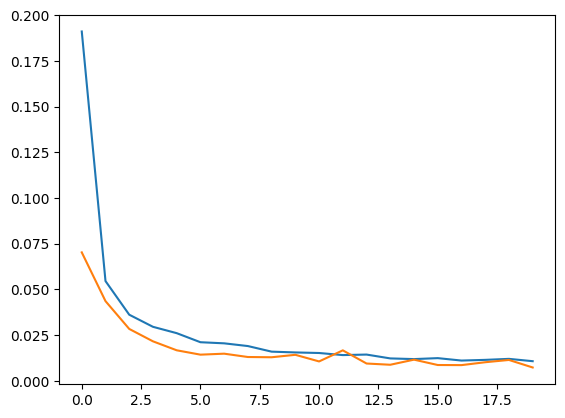

In [217]:
# Lists to store training and validation losses
t_losses, v_losses = [], []
# Loop over epochs
for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0

    # train step
    model.train()
    # Loop over train dataset
    for x, y in trainloader:
        optimizer.zero_grad()
        # move inputs to device
        x = x.to(device)
        y  = y.squeeze().to(device)
        # Forward Pass
        preds = model(x).squeeze()
        loss = criterion(preds, y) # compute batch loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(trainloader)
    t_losses.append(epoch_loss)

    # validation step
    model.eval()
    # Loop over validation dataset
    for x, y in testloader:
        with torch.no_grad():
          x, y = x.to(device), y.squeeze().to(device)
          preds = model(x).squeeze()
          error = criterion(preds, y)
        valid_loss += error.item()
    valid_loss = valid_loss / len(testloader)
    v_losses.append(valid_loss)

    print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')

plt.plot(t_losses)
plt.plot(v_losses)
plt.show()


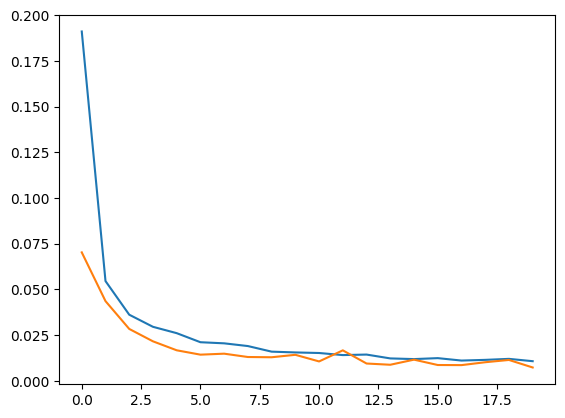

In [219]:
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

In [220]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
            actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions.squeeze(), actuals

predicted, true = make_predictions_from_dataloader(model, unshuffled_trainloader)


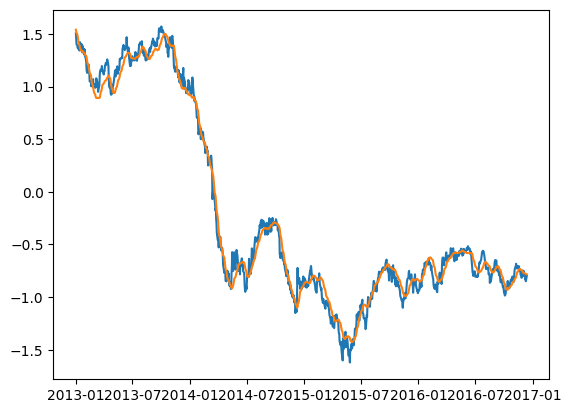

In [222]:

plt.plot(dates,true)
plt.plot(dates,predicted)
plt.show()

{'date': StandardScaler(), 'dcoilwtico': StandardScaler()}

995

In [158]:
df

,date,dcoilwtico
1,-1.729626,0.992430
2,-1.727593,0.985795
3,-1.725560,0.991650
4,-1.719461,0.994772
5,-1.717428,0.995163
...,...,...
1213,1.718400,-0.783166
1214,1.724500,-0.831957
1215,1.726533,-0.829615
1216,1.728566,-0.849131
